In [20]:
import math
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import yfinance as yf
import datetime

In [21]:
# Download historical stock data
start_date = '1970-01-01'
end_date = '2023-08-23'
df =  yf.download('^GSPC', start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [22]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-01-02,0.000000,93.540001,91.790001,93.000000,93.000000,8050000
1970-01-05,0.000000,94.250000,92.529999,93.459999,93.459999,11490000
1970-01-06,0.000000,93.809998,92.129997,92.820000,92.820000,11460000
1970-01-07,0.000000,93.379997,91.930000,92.629997,92.629997,10010000
1970-01-08,0.000000,93.470001,91.989998,92.680000,92.680000,10670000
...,...,...,...,...,...,...
2023-08-16,4433.790039,4449.950195,4403.549805,4404.330078,4404.330078,3753910000
2023-08-17,4416.319824,4421.169922,4364.830078,4370.359863,4370.359863,3943700000
2023-08-18,4344.879883,4381.819824,4335.310059,4369.709961,4369.709961,3940400000


In [23]:
# Create a new DataFrame containing only the "Close" column.
data = df.filter(["Adj Close"])
data

,Adj Close
Date,
1970-01-02,93.000000
1970-01-05,93.459999
1970-01-06,92.820000
1970-01-07,92.629997
1970-01-08,92.680000
...,...
2023-08-16,4404.330078
2023-08-17,4370.359863
2023-08-18,4369.709961


In [24]:
# Convert the DataFrame into a NumPy array.
dataset = data.values

# Get the number of rows to train the model on.
length = math.ceil(len(dataset) * 0.8)

In [25]:
# Rescale the data between 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [26]:
scaled_data

array([[0.00648884],
       [0.00658601],
       [0.00645082],
       ...,
       [0.90983844],
       [0.91618788],
       [0.91360666]])

In [27]:
train_data = scaled_data[0:length, :]

In [28]:
# Split the data into x_train and y_train.
x_train = []
y_train = []

# Number of days
num_days = 100

for i in range(num_days, len(train_data)):
    x_train.append(train_data[i-num_days:i, 0])
    y_train.append(train_data[i, 0])

In [29]:
# Convert x_train and y_train into NumPy arrays.
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data.
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

# Build the LSTM model.
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(64))
model.add(Dense(1))

In [30]:
# Compile the model.
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model.
model.fit(x_train, y_train, batch_size=64, epochs=10)

# Create the test data set.
test_data = scaled_data[length - num_days:, :]

Epoch 1/10
168/168 [==============================] - 49s 265ms/step - loss: 4.7480e-04
Epoch 2/10
168/168 [==============================] - 44s 261ms/step - loss: 1.5699e-05
Epoch 3/10
168/168 [==============================] - 46s 275ms/step - loss: 1.4968e-05
Epoch 4/10
168/168 [==============================] - 47s 281ms/step - loss: 1.5338e-05
Epoch 5/10
168/168 [==============================] - 47s 280ms/step - loss: 1.3380e-05
Epoch 6/10
168/168 [==============================] - 45s 268ms/step - loss: 1.3055e-05
Epoch 7/10
168/168 [==============================] - 45s 267ms/step - loss: 1.4154e-05
Epoch 8/10
168/168 [==============================] - 45s 266ms/step - loss: 1.3220e-05
Epoch 9/10
168/168 [==============================] - 44s 260ms/step - loss: 1.3655e-05
Epoch 10/10
168/168 [==============================] - 45s 267ms/step - loss: 1.4409e-05


In [31]:
# Create the x_test and y_test datasets.
x_test = []
y_test = dataset[length:, :]

for i in range(num_days, len(test_data)):
    x_test.append(test_data[i-num_days:i, 0])

# Convert the data into a NumPy array.
x_test = np.array(x_test)

# Reshape the data.
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [32]:
# Get model predictions on prices.
predictions = model.predict(x_test)

# Inverse transform the predictions to the original scale.
predictions = scaler.inverse_transform(predictions)

85/85 [==============================] - 7s 72ms/step


In [36]:
# Show data
train = data[:length]
prices = data[length:]
prices["Predictions"] = predictions

<ipython-input-36-f243037c69fa>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices["Predictions"] = predictions


In [37]:
prices

,Adj Close,Predictions
Date,,
2012-11-21,1391.030029,1359.673584
2012-11-23,1409.150024,1361.864868
2012-11-26,1406.290039,1366.808716
2012-11-27,1398.939941,1372.797363
2012-11-28,1409.930054,1378.222046
...,...,...
2023-08-16,4404.330078,4276.186523
2023-08-17,4370.359863,4264.834473
2023-08-18,4369.709961,4249.268066


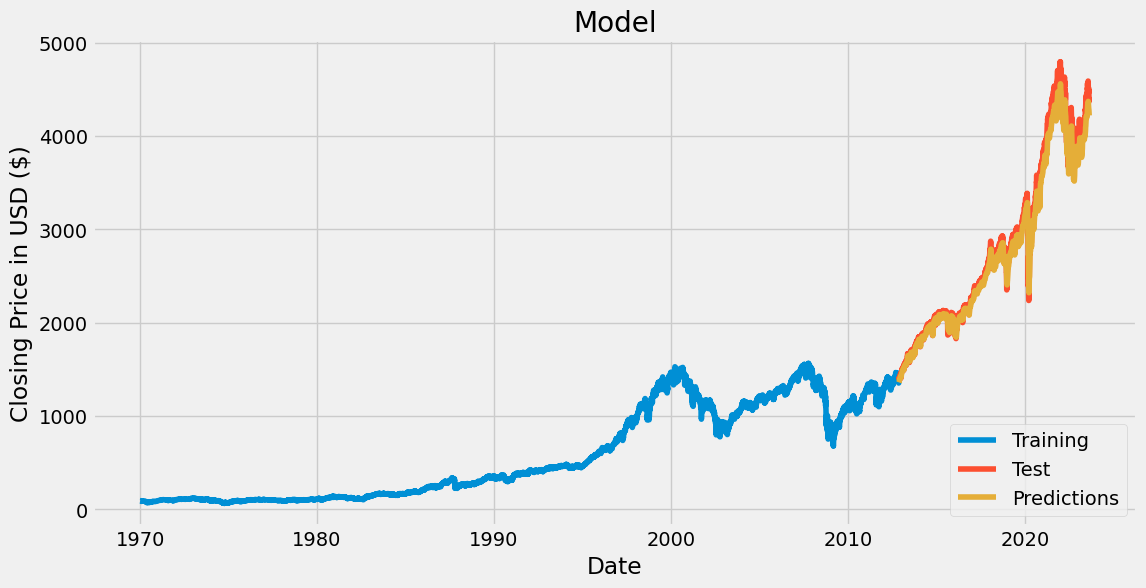

In [38]:
# Create a figure for plotting.
plt.figure(figsize=(12, 6))
plt.title("Model")
plt.xlabel("Date")
plt.ylabel("Closing Price in USD ($)")
plt.plot(train["Adj Close"])  # Plot the training data
plt.plot(prices[["Adj Close", "Predictions"]])  # Plot the test and predicted prices
plt.legend(["Training", "Test", "Predictions"], loc="lower right")
plt.grid(True)
plt.show()